In [2]:
# Data Analysis
import numpy as np
# Plotting & Visualization
from matplotlib import pyplot as plt
# Image processing
from skimage import io, exposure, measure, filters, morphology, segmentation
from PIL import Image
import scipy.ndimage as ndi
# Output Display
import napari

# Image Reading

In [ ]:
#tiff_stack = io.imread("D:/Get to Work/John's/40_nm_DL_cropped.tif", plugin="tifffile")
#print(tiff_stack.shape)

In [3]:
file_path="D:/Get to Work/John's/40_nm_DL_cropped.tif"
dataset = Image.open(file_path)
tiff_stack = np.zeros((25, np.shape(dataset)[0], np.shape(dataset)[1])) #dataset.n_frames
for i in range(25):
   dataset.seek(i)
   tiff_stack[i,:,:] = np.array(dataset)
tiff_stack = tiff_stack.astype(np.float32);
print(tiff_stack.shape)

(25, 672, 657)


## ~~Image Normalization~~

In [337]:
#norm_img = (original_img-original_img.min())/(original_img.max()-original_img.min())
# One can multiply the previous expression by some x value to standardize in terms of it. For instance, x here is 1.

# Filteration (mainly Gaussian-based and maybe Mean for bleach detection)

In [338]:
#smoothed = filters.gaussian(tiff_stack, sigma=1, mode='constant')
#fil_norm = (filtered-filtered.min())/(filtered.max()-filtered.min())

DoG

In [4]:
smoothed = filters.difference_of_gaussians(tiff_stack, low_sigma=0.56, high_sigma=ndi.standard_deviation(tiff_stack), mode='constant', channel_axis=0)
# high_sigma is not neccessarily right using scipy.ndimage.standard_deviation

LoG

In [358]:
#smoothed = ndi.gaussian_laplace(tiff_stack, sigma=0.9, mode='constant')
# Invert the threshold value (i.e., multiply by negative sign)
# Still not customized properly in our case.

Histogram equalization

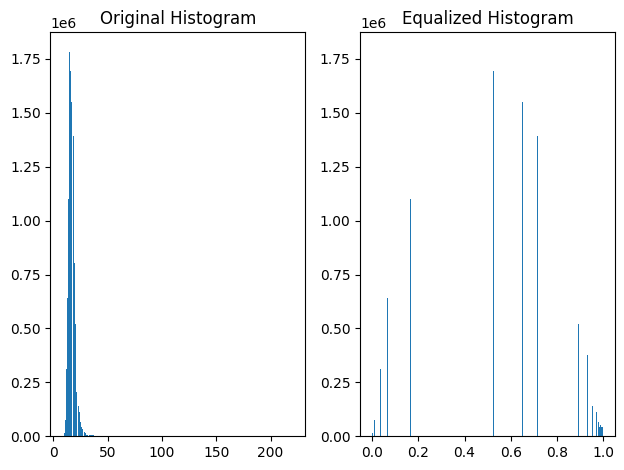

In [359]:
equalized = exposure.equalize_hist(tiff_stack)

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].hist(tiff_stack.ravel(), bins=256)
ax[0].ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
ax[0].set_title('Original Histogram')

ax[1].hist(equalized.ravel(), bins=256)
ax[1].ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
ax[1].set_title('Equalized Histogram')

fig.tight_layout()

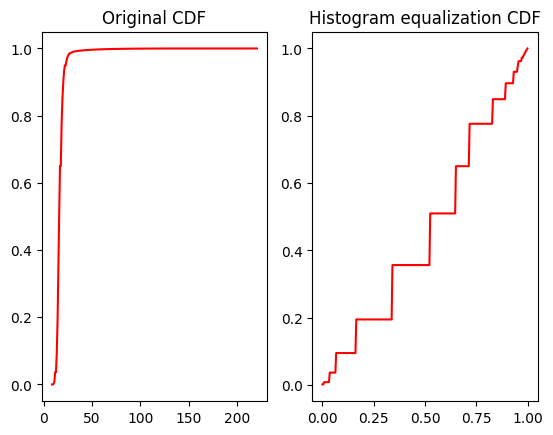

In [360]:
fig, ax = plt.subplots(nrows=1, ncols=2)

cdf, bins = exposure.cumulative_distribution(tiff_stack.ravel())
ax[0].plot(bins, cdf, "r")
ax[0].set_title("Original CDF");

cdf, bins = exposure.cumulative_distribution(equalized.ravel())
ax[1].plot(bins, cdf, "r")
ax[1].set_title("Histogram equalization CDF");

# Segmentation

In [6]:
thresh_val = filters.threshold_otsu(smoothed)
print(thresh_val)

17.469643


Check Threshold Effectiveness

Text(0.5, 1.0, 'Threshold Validation Histogram')

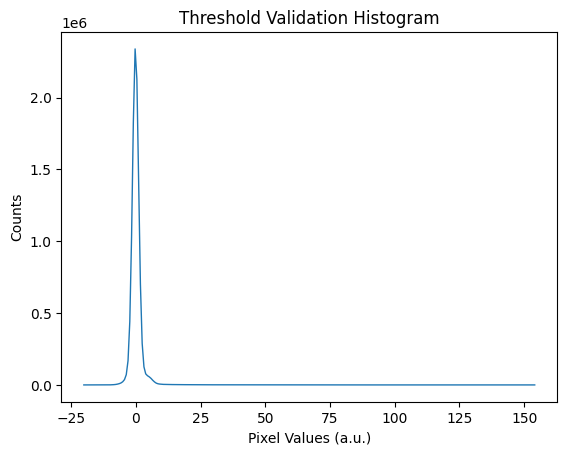

In [362]:
hist, bins = exposure.histogram(smoothed)
plt.plot(bins, hist, linewidth=1)
plt.xlabel('Pixel Values (a.u.)')
plt.ylabel('Counts')
plt.title('Threshold Validation Histogram')
# If the thresholding value is not to user's liking, modify it accordingly.
#thresh_val = VALUE

In [7]:
segmented = smoothed > thresh_val
print(segmented.shape)

(25, 672, 657)


**Trial & Error (for best results from both filtering and thresholding)**

Text(0.5, 1.0, '1st Frame Masked Image')

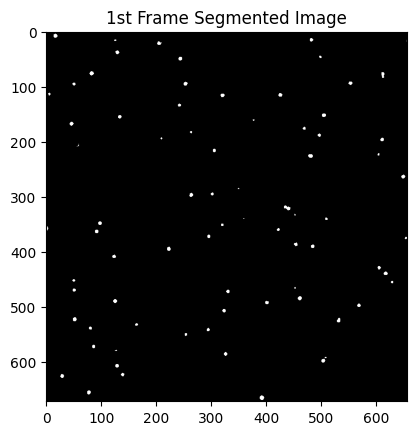

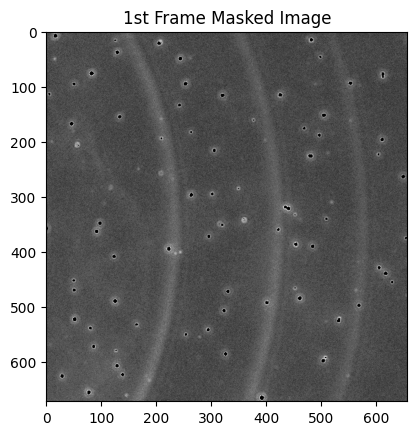

In [8]:
gray = plt.cm.Greys_r

orig_dublicate = np.copy(tiff_stack[0, :, :])
orig_dublicate[segmented[0, :, :]] = 1.0

plt.figure()
plt.imshow(segmented[0, :, :], cmap=gray)
plt.title('1st Frame Segmented Image')
plt.figure()
plt.imshow(orig_dublicate, cmap=gray)
plt.title('1st Frame Masked Image')

# Seeding & Expansion

Distance Transform

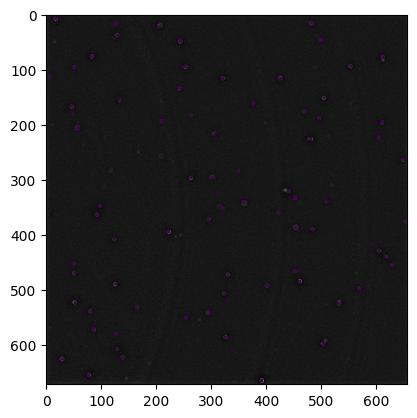

In [12]:
transformed = ndi.distance_transform_edt(segmented[0, :, :])
transformed = ndi.maximum_filter(transformed, size=5)
from skimage.feature import peak_local_max
img_max = morphology.local_maxima(transformed, indices=False)
#img_max = ndi.label(img_max)[0]

plt.imshow(smoothed[0, :, :], cmap='gray', interpolation='none')
plt.imshow(np.ma.array(img_max, mask=img_max==0), interpolation='none') 
plt.show()

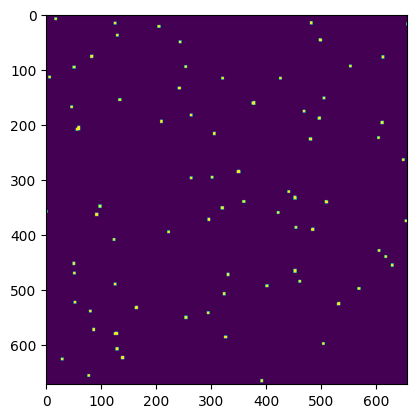

In [13]:
plt.imshow(img_max)

Watershed Transform

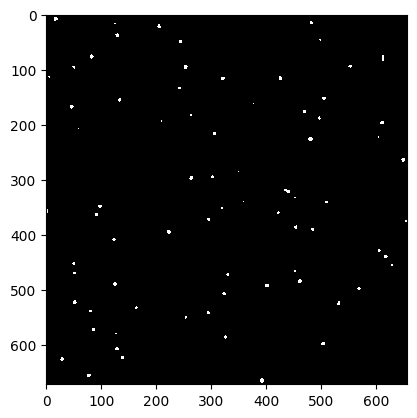

In [14]:
expanded = segmentation.watershed(transformed.astype(np.uint8), img_max.astype(np.int8), mask=segmented[0, :, :])

plt.imshow(smoothed[0, :, :], cmap='gray', interpolation='none')
plt.imshow(expanded, cmap='gray', interpolation='none') 
plt.show()